# Time series measures

**This notebook investigates different Time Series measures from the `PyInform` python library**

For further info check:\
https://elife-asu.github.io/PyInform/timeseries.html \
https://github.com/ELIFE-ASU/PyInform

## Work plan

* Load data sets
* Filter frequencies using Thomas code
* On each filtered frequencies, compute entropy measures
* Plot evolution of entropy for each patient, segment per segment

In [1]:
from pyinform import active_info
from pyinform import block_entropy
from pyinform import entropy_rate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import numpy as np
import os

In [2]:
from sklearn.preprocessing import RobustScaler
from numpy.fft import rfft, irfft, rfftfreq
from scipy import fftpack

## Build and sort list of files

In [3]:
folder_path = '/Users/commander/code/jhupiterz/SafeSeizure/raw_data'
files_patient1 = []
files_patient2 = []

dirs = ['Patient_1_csv', 'Patient_2_csv']
for f in os.listdir(os.path.join(folder_path,dirs[0],'train_segments_unlabelled')):
    if f.startswith('preictal'):
        files_patient1.append(f)
    
for f in os.listdir(os.path.join(folder_path,dirs[1],'train_segments_unlabelled')):
    if f.startswith('preictal'):
        files_patient2.append(f)

In [4]:
# Function to sort file names alphanumerically
import re
def sorted_nicely(l):
    """ Sorts the given iterable in the way that is expected.
    Required arguments:
    l -- The iterable to be sorted.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [5]:
files_patient1 = sorted_nicely(files_patient1)
files_patient2 = sorted_nicely(files_patient2)

## Filter gamma frequencies (after Thomas code)

In [6]:
def scaler(df):
    return RobustScaler().fit_transform(df)

def decompose_brainwaves(data):
    delta = (0,4)
    theta = (4.5,8)
    alpha = (8.5,12)
    beta = (12.5,35)
    gamma = (35, 100)

    frequencies = rfftfreq(data.size, d=1/data.size)

    fourier = rfft(data)
    
    output = []
    for i in (alpha, beta, delta, theta, gamma):
        #print(i)
        ft_threshed = fourier.copy()
        ft_threshed[(frequencies < i[0])] = 0
        ft_threshed[(frequencies > i[1])] = 0 
        output.append(irfft(ft_threshed))
    
    return output

def plot_brainwaves(data, subject=str):
    fig, axarr = plt.subplots(len(data), figsize=(20, 12))
    for i, signal in enumerate(data):
        plt.sca(axarr[i])
        plt.plot(signal)
    plt.gcf().suptitle(f"frequency bands: {subject} data", fontsize=24)
    

def plot_single_wave(data, label=str):
    plt.figure(figsize=(20,12))
    plt.xlim=(0,len(data))
    plt.ylim=(-0.75,0.75)
    sns.lineplot(data=data, label=label)
    plt.legend()
    plt.gcf().suptitle(f"Gamma band: {label}", fontsize=24)

### Demo: frequencies filter

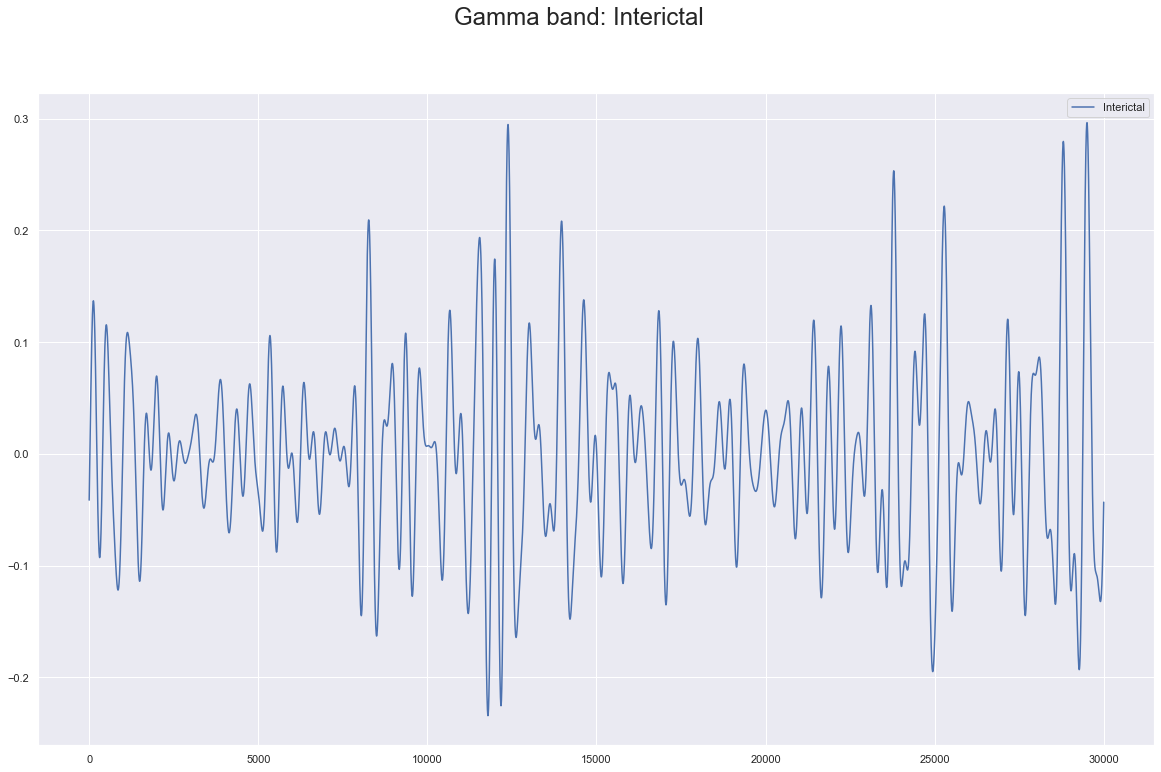

In [7]:
demo = pd.read_csv('../raw_data/Patient_1_csv/train_segments_unlabelled/interictal_segment_15.csv')
plot_single_wave(decompose_brainwaves(pd.DataFrame(scaler(demo)).iloc[0])[4], label = 'Interictal')

## Entropy measures

### Evolution of entropy in preictal state

In [7]:
def compute_entropy(patient, entropy_metric, filtered = False):
    if patient == 1:
        directory = 'Patient_1_csv'
        files = files_patient1
    elif patient == 2:
        directory = 'Patient_2_csv'
        files = files_patient2
    patient_entropies = []
    for f in files:
        segment_entropies = []
        data = pd.read_csv(f'../raw_data/{directory}/train_segments_unlabelled/{f}')
        if filtered == True:
            data = pd.DataFrame(scaler(data))
        for index, row in data.iterrows():
            electrode = row
            if filtered == True:
                gamma_electrode = decompose_brainwaves(electrode)[4]
                electrode_pos = gamma_electrode + abs(gamma_electrode.min())
            else:
                electrode_pos = electrode + abs(electrode.min())
            if entropy_metric == 'block_entropy':
                entropy = block_entropy(electrode_pos, k=1)
            elif entropy_metric == 'entropy_rate':
                entropy = entropy_rate(electrode_pos, k=1)
            segment_entropies.append(entropy)
        patient_entropies.append(segment_entropies)
    
    return pd.DataFrame.from_records(patient_entropies).T

In [8]:
def plot_entropy(patient, entropy_metric, filtered = False):
    plt.figure(figsize=(15,8))
    for index, row in compute_entropy(patient, entropy_metric).iterrows():
        plt.plot(row, color = 'darkgrey')
    plt.title(f'Evolution of {entropy_metric} in preictal state - Patient {patient} - data filtered = {filtered}')
    #plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Block entropy');

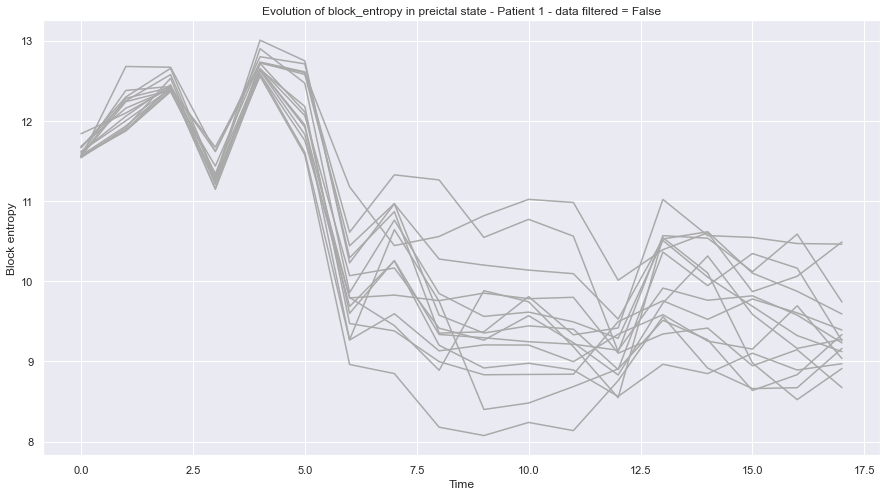

In [10]:
plot_entropy(patient=1, entropy_metric= 'block_entropy')

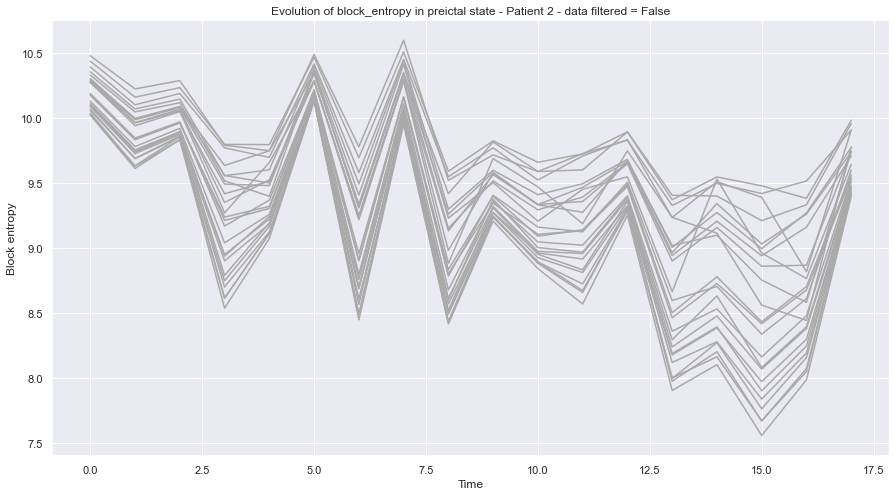

In [27]:
plot_entropy(patient=2, entropy_metric= 'block_entropy')

In [ ]:
plot_entropy(patient=1, entropy_metric= 'entropy_rate')

In [ ]:
plot_entropy(patient=2, entropy_metric= 'entropy_rate')

## Summary

**In summary, whether the data is filtered or not, entropy measures do not seem to help identifying patterns within the preictal state for any of the patients.**